# Importing Libraries

In [ ]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
#from sklearn.preprocessing import Imputer
from sklearn.impute import SimpleImputer
from sklearn.feature_selection import VarianceThreshold
from collections import Counter
%matplotlib inline

from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.utils import resample
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.metrics import f1_score
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import LinearSVC
from xgboost import XGBClassifier

import warnings
warnings.filterwarnings('ignore')

# Useful user defined functions

In [ ]:
# This function gives the percentage of null values in every column if null values exists 
# and also returns a list of columns which has null values

def null_value_check(train):
    missing = []

    for columns in train.columns:
        missing_count = train[train[columns] == -1][columns].count()
        if missing_count > 0:
            missing.append(columns)
            missings_perc = missing_count*100/train.shape[0]

            print('Variable %s has %i missing with %f percentage'%(columns, missing_count, missings_perc))

    print('\nIn total, there are {} variables with missing values'.format(len(missing)))
    return missing

In [ ]:
# This function gives the number of outliers in the columns 
# and also returns the columns with outliers

def detect_outlier(df):
    features = df.columns
    outliers  = []
    for i, feature in enumerate(features):
        if df[feature].dtype == 'float64':
            # Calculate Q1 (25th percentile of the data) for the given feature
            Q1 = np.percentile(df[feature], 25)
            # Calculate Q3 (75th percentile of the data) for the given feature
            Q3 = np.percentile(df[feature], 75)
            # Use the interquartile range to calculate an outlier step
            step = 1.5 * (Q3 - Q1)
            feature_outliers = df[~((df[feature] >= Q1 - step) & (df[feature] <= Q3 + step))]
            outliers.extend(list(feature_outliers.index.values))
            print('Feature: {}, outliers: {}\n'.format(feature, len(feature_outliers.index)))
    
    multi_feature_outliers = (Counter(outliers) - Counter(set(outliers))).keys()
    return multi_feature_outliers

In [ ]:
# This function is used to handle imbalanced dataset. It upsamples the minority class and downsamples the majority classz

def up_and_down_sampling(df_train_temp,minority_class_percent):
    #Downsampling
    
    df_majority = df_train_temp[df_train_temp.target==0]
    df_minority = df_train_temp[df_train_temp.target==1]
    df_rows = df_train_temp.shape[0]
    n_samples=int(df_rows*((100 - minority_class_percent)/100))
    # Downsample majority class
    df_majority_undersampled = resample(df_majority, 
                                     replace=True,     # sample with replacement
                                     n_samples=n_samples,  # number of samples we want for majority variable
                                     random_state=123) # reproducible results

    # Combine minority class with Downsampled df
    df_undersampled = pd.concat([df_majority_undersampled, df_minority])

    # Display new class counts
    print("Target value counts after downsampling: \n" , df_undersampled.target.value_counts())
    

    #Upsampling

    df_majority = df_undersampled[df_undersampled.target==0]
    df_rows = df_train_temp.shape[0]
    n_samples=int(df_rows*(minority_class_percent/100))
    # Upsample minority class
    df_minority_upsampled = resample(df_minority, 
                                     replace=True,     # sample with replacement
                                     n_samples=n_samples, # number of samples we want for minority variable
                                     random_state=123) # reproducible results

    # Combine majority values with upsampled minority df
    df_upsampled = pd.concat([df_majority, df_minority_upsampled])

    # Display new class counts
    print("\nTarget value counts after upsampling: \n" , df_upsampled.target.value_counts())
    
    
    return df_upsampled

# Loading the dataset from train.CSV file

In [ ]:
train = pd.read_csv('train(1).csv')

# Data Summary

### 1.	Write at least 3 important inferences from the data above 

•	Target column is imbalanced

•	4 types of columns

•	Outliers

•	Null values

•	6 variables have too low variance.

In [ ]:
print("• The dataset has " + str(train.shape[0]) + " rows and " + str(train.shape[1]) + " columns")

## MetaData DataFrame for Reference

In [ ]:
#Creating Metadata DataFrame so that it will be easy to handle and manipulate data during data exploration steps

#role: input, ID, target
#level: nominal, interval, ordinal, binary
#keep: True or False
#dtype: int, float, str

MetaData = pd.DataFrame(columns=['variable','role', 'level', 'keep', 'dtype'])
data =[]
for columns in train.columns:
    
    #Defining Role
    
    if columns == 'id':
        role = 'id'
    elif columns == 'target':
        role = 'target'
    else:
        role = 'input'
        
    #Defining DataTypes
    
    dtype = train[columns].dtype
    
    #Defining keep
    
    keep = True
    
    #Defining Level
    
    if columns[-3:] == 'bin' or columns == 'target':
        level = 'binary'
    elif columns[-3:] == 'cat' or columns == 'id':
        level = 'categorical' 
    elif train[columns].dtype == float:
        level = 'interval'
    elif train[columns].dtype == np.int64:
        level = 'ordinal'
        
        
    f_dict = {
        'variable' : columns,
        'role': role,
        'level': level,
        'keep': keep,
        'dtype': dtype
    }
    
    data.append(f_dict)

MetaData = MetaData.append(data)

### 2.	Is the data balanced? Meaning are targets 0 and 1 in the right proportion? 

In [ ]:
#Count of target variable.

sns.countplot(train.target)
train.groupby('target')['target'].count()

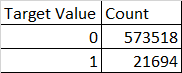

Data is highly imbalance with only ~3% of data belongs to minority (which is 1 in target) class. Need to do upscaling/down sampling after train-test split of data to get the desired results


In [ ]:
#Checking the Distribution of variables across levels

MetaData.groupby('level')[['variable']].count()

### 3.	How many categorical features are there? 

15 Categorical features are there.

### 4.	How many binary features are there? 

18 Binary features are there.

## Missing Values

In [ ]:
missing = null_value_check(train)

### 11.	Which are the top two features in terms of missing values? 

ps_car_03_cat, ps_car_05_cat have high percentage of missing values.

### 12.	In total, how many features have missing values? 

In total, there are 12 variables with missing values

In [ ]:
MetaData.loc[MetaData['variable'] == 'ps_car_03_cat', 'keep'] = False
MetaData.loc[MetaData['variable'] == 'ps_car_05_cat', 'keep'] = False

In [ ]:
#Removing variables that has high missing value count i.e ps_car_03_cat and ps_car_05_cat

train1 = train.drop(['ps_car_03_cat', 'ps_car_05_cat'], axis = 1)

In [ ]:
vars_to_drop = ['ps_car_03_cat', 'ps_car_05_cat']

# Imputing with the mean for non categorical variables

mean_imp = SimpleImputer(missing_values=-1, strategy='mean')
mode_imp = SimpleImputer(missing_values=-1, strategy='most_frequent')
train1['ps_reg_03'] = mean_imp.fit_transform(train1[['ps_reg_03']]).ravel()
train1['ps_car_12'] = mode_imp.fit_transform(train1[['ps_car_12']]).ravel()
train1['ps_car_14'] = mean_imp.fit_transform(train1[['ps_car_14']]).ravel()
train1['ps_car_11'] = mode_imp.fit_transform(train1[['ps_car_11']]).ravel()

#Imputing missing values in categorical variables by their Mode

filtered_missing = [ i for i in missing if not i in vars_to_drop]

for columns in filtered_missing:
    train1.loc[train1[columns] == -1, columns] = train1[columns].mode()[0]

### 13.	What steps should be taken to handle the missing data? 

We can remove variable ps_car_03_cat, ps_car_05_cat as they have high percentage of missing values. For other variables, we can do missing value treatment by substituting mean and mode.
Missing values in Categorical variables can be replaced by the mode value in that variable.

In [ ]:
#Checking missing values in the data, if any.
null_value_check(train1)

In [ ]:
print("Shape of before null values check: ", train.shape)
print('\nShape of after null values check: ', train1.shape)

## Correlation

In [ ]:
#Correlation between different types of variables
#Creating list of interval, categorical, binary and ordinal variables

for variable in MetaData.variable:
    IntervalVar = MetaData[MetaData.level=='interval']['variable']
    CategoricalVar = MetaData[MetaData.level=='categorical']['variable']
    BinaryVar = MetaData[MetaData.level=='binary']['variable']
    OrdinalVar = MetaData[MetaData.level=='ordinal']['variable']
    
all_variables = [IntervalVar, CategoricalVar, BinaryVar, OrdinalVar]

for x in all_variables:
    fig, ax = plt.subplots(figsize=(20,10))
    sns.heatmap(train[x].corr(), annot=True)

### 14.	Which interval variables have strong correlation? 

Interval Variables: We can see the following variables are highly correlated 
ps_reg_01
ps_reg_02
ps_reg_03
ps_reg_12
ps_reg_13
ps_reg_15

### 15.	What's the level of correlation among ordinal features? 

Ordinal Variables: Very few are correlated to each other(negligible)

In [ ]:
# Now working for correlation in "IND"

ind_col = [w for w in train1.columns if 'ind' in w]

fig, ax = plt.subplots(figsize=(15,10))  
sns.heatmap(train1[ind_col].corr(), annot= True)

In [ ]:
# PS_ind_06_bin and PS_ind_07_bin high correlation - so we drop PS_ind_06_bin
# ps_ind_16_bin corr with ps_ind_17_bin and ps_ind_18_bin so we drop ps_ind_16_bin
train2 = train1.drop(["ps_ind_06_bin", "ps_ind_16_bin"], axis = 1)

In [ ]:
#Checking correlation of 'car' variables
car_col = [w for w in train2.columns if 'car' in w]
fig, ax = plt.subplots(figsize=(15,10))  
sns.heatmap(train2[car_col].corr() > 0.5, annot= True)

In [ ]:
#Droping variable 'ps_car_15' as it is highly correlated with the variable 'ps_car_13' and checking the shape of resulting
#dataframe

train3 = train2.drop(["ps_car_15"], axis = 1)

In [ ]:
#Removing calculated variables since there correlation with target variable is non significant

column_excluding_calc  = [w for w in train3.columns if "calc" not in w]
train4 = train3[column_excluding_calc]

In [ ]:
#checking correlation of "REG" variables

reg_col = [w for w in train4.columns if 'reg' in w]
fig, ax = plt.subplots(figsize=(8,5))  
sns.heatmap(train4[reg_col].corr(), annot= True)

#Reg variable seems to somewhat related
#Creating interaction variables for 'reg' variables since they are highly correlated
#Taking sum of ps_reg_01,ps_reg_03 and ps_reg_02
#Droping variables 'ps_reg_01 and ps_reg02

In [ ]:
print("Number of columns before correlation check: ", train1.shape[1])
print('\nNumber of columns after correlation check: ', train4.shape[1])

## Outliers

In [ ]:
outliers  = detect_outlier(train4.drop(['id', 'target'], axis = 1))

In [ ]:
#Removing outliers from the dataframe

train5 = train4.drop(train4.index[list(outliers)]).reset_index(drop = True)

print('Number of outliers in more than one feature: {}'.format(len(outliers)))
print('Shape of old data: {}'.format(train4.shape))
print('Shape of new data: {}'.format(train5.shape))

## Variance

In [ ]:
#Removing low variance variables from the dataframe

#Checking the number of low variance variables in the data using VarianceThreshold from sklearn feature_selection 


selector = VarianceThreshold(threshold=.01)
selector.fit(train5.drop(['id', 'target'], axis=1)) # Fit to train without id and target variables

f = np.vectorize(lambda x : not x) # Function to toggle boolean array elements

v = train5.drop(['id', 'target'], axis=1).columns[f(selector.get_support())]
print('{} variables have too low variance.'.format(len(v)))
print('\nThese variables are {}'.format(list(v)))

## Feature engineering

In [ ]:
#Dropping the low variance variables from the data and checking the shape of the final dataframe

train6 = train5.drop(list(v), axis = 1)
print('\nShape of df before removal of low variance rows: ',train5.shape)
print('Shape of df after removal of low variance rows: ',train6.shape)

In [ ]:
#Creating interaction variables for 'reg' variables since they are highly correlated
#Taking sum of reg variable

train6["sum_reg"] = train6["ps_reg_01"] + train6["ps_reg_02"] + train6["ps_reg_03"]

#Droping variables 'ps_reg_01 and ps_reg02

train7 = train6.drop(["ps_reg_01", "ps_reg_02"], axis = 1)

### 5.	Write inferences from data on interval variables. 

•	Variable “ps_reg_03” has 107772 missing values with 18.106490 percentage.

•	We can see some of the variables are highly correlated like - ps_reg_01, ps_reg_02, ps_reg_03

•	“ps_car_12” has very low variance.

•	Features ps_reg_02, ps_reg_03, ps_car_12, ps_car_13, ps_car_14 and ps_car_15 have outliers.

### 6.	Write inferences from data on ordinal variables. 

•	No null values in ordinal variables.

•	Very few are correlated to each other(negligible)

### 7.	Write inferences from data on binary variables. 

•	“ps_ind_10_bin”, “ps_ind_11_bin”, “ps_ind_12_bin”, “ps_ind_13_bin” have very low variance.

•	“ps_ind_06_bin” and “ps_ind_07_bin” are significantly correlated.

In [ ]:
#Handling Categorical Variables
#Creating dummy variables using get_dummies

#Creating list of categorical variables

cat_feat = MetaData[(MetaData.level == 'categorical') & (MetaData.keep == True)].variable

#Creating dummy variables of categorical variables except variable - ps_car_11_cat as it conatins more than 100 categories

v = MetaData[(MetaData.level == 'categorical') & (MetaData.keep)].variable
v = [w for w in list(v) if w!='id' and w!='ps_car_11_cat']

#Printing number of variables before and after dummification

print('Before dummification we have {} variables in train'.format(train7.shape[1]))
train8 = pd.get_dummies(train4, columns=v, drop_first=True)
print('After dummification we have {} variables in train'.format(train8.shape[1]))

### 16. Implement Hot Encoding for categorical features 

write the answer

In [ ]:
#Splitting
X_train, X_test, y_train, y_test = train_test_split(train8.drop(['target', 'id'], axis=1),
                                                    train8['target'].astype(int), 
                                                    test_size=0.30, 
                                                    random_state=101)

In [ ]:
df_train_temp = X_train
df_train_temp['target'] = y_train

In [ ]:
df_train_temp.shape

### 9.	What should be the preferred way in this case to balance the data? 

Need to do upscaling/down sampling after train-test split of data to get the desired results

In [ ]:
df_sampled = up_and_down_sampling(df_train_temp,20)
X_train_res = df_sampled.drop('target', axis = 1)
y_train_res = df_sampled.target

In [ ]:
test_sampled = up_and_down_sampling(df_train_temp,12)

### 10.	How many training records are there after achieving a balance of 12%? 

To obtain a balance between majority and minority class, we used sampling techniques. After sampling there are there are 416648 rows in which 3,66,650 are 0s and 49,997 are 1s

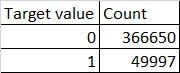

## Feature Scaling

In [ ]:
mms = StandardScaler()
X_train_res_scaled = mms.fit_transform(X_train_res)
#y_train_res_scaled = mms.fit_transform(y_train_res)

### 17.	In nominal(categorical) and interval features, which features are suitable for StandardScaler? 

write the answer

# Model Building

## Logistic Regression

In [ ]:
lm = LogisticRegression()
logistic_model = lm.fit(X_train_res, y_train_res)
predictions_LM = logistic_model.predict(X_test)
print(' Classification Report of Logistic Regression is: \n')
CR_LM = classification_report(y_test,predictions_LM) 
print(CR_LM)

print('Confusion Matrix Logistic Regression is : \n')
print(confusion_matrix(y_test,predictions_LM))
print(f1_score(y_test, predictions_LM))

### 1.	The Simple Logistic Regression Model seems to have high accuracy. Is that what we need at all? What is the problem with this model?


Simple Logistic Regression Model seems to high accuracy but Logistic regression is a linear model, so it may not work well on non-linear cases. In terms of model complexity, logistic regression has high bias and low variance. So, it might work well if you handle the outliers well but after model deployment, we cannot rely on the predictions because of the high bias and low variance characteristics of Logistic Regression.


### 2.	Why do you think f1-score is 0.0?

Write the answer

## Random Forest

In [ ]:
clf_RF = RandomForestClassifier(n_estimators=25, class_weight="balanced")
clf_RF.fit(X_train_res,y_train_res)
predictions_RF = clf_RF.predict(X_test)

print(' Classification Report of RandomForest Classifier is: \n')
CR_RF = classification_report(y_test,predictions_RF) 
print(CR_RF)

print('Confusion matrix of RandomForest Classifier is: \n')
print(confusion_matrix(y_test,predictions_RF))
print(f1_score(y_test, predictions_RF))

### 3.	What is the precision and recall score for the model?

I have opted for Random Forest Classifier. So, the precision and recall score for my model are

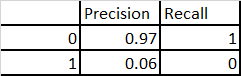

### 4.	What is the most important inference you can draw from the result?

write the answer

### 5.	Why do you think f1-score has improved?

write the answer

## Linear Support Vector Classifier - (dual = True and max_iter = 500)

In [ ]:
clf_LSVC_1 = LinearSVC(dual = True , max_iter = 500)
clf_LSVC_1.fit(X_train_res , y_train_res)
predictions_LSVC_1 = clf_LSVC_1.predict(X_test)

print(' Classification Report of  Linear Support Vector Classifier is: \n')
CR_LSVC_1 = classification_report(y_test,predictions_LSVC_1) 
print(CR_LSVC_1)

print('Confusion Matrix Linear Support Vector Classifier is: \n')
print(confusion_matrix(y_test,predictions_LSVC_1))
print(f1_score(y_test,predictions_LSVC_1))

## Linear Support Vector Classifier - (dual = False and max_iter = 1000)

In [ ]:
clf_LSVC_2 = LinearSVC(dual = False , max_iter = 2000)
clf_LSVC_2.fit(X_train_res , y_train_res)
predictions_LSVC_2 = clf_LSVC_2.predict(X_test)

print(' Classification Report of  RandomForest Classifier is: \n')
CR_LSVC_2 = classification_report(y_test,predictions_LSVC_2) 
print(CR_LSVC_2)

print('Confusion Matrix Linear Support Vector Classifier is: \n')
print(confusion_matrix(y_test,predictions_LSVC_2))
print(f1_score(y_test,predictions_LSVC_2))

### 6.	For model LinearSVC play with parameters – dual, max_iter and see if there is any improvement.

Didn’t find any improvement after tweaking the parameters.

## SVM with Only 100k records

In [ ]:
train8.shape

In [ ]:
train9 = train8[:100000]
train9.shape

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(train9.drop(['target', 'id'], axis=1),
                                                    train9['target'].astype(int), 
                                                    test_size=0.30, 
                                                    random_state=101)

In [ ]:
df_train_temp = X_train
df_train_temp['target'] = y_train

In [ ]:
train9['target'].hist()

In [ ]:
#upsampling and downsampling
df_upsampled_SVM = up_and_down_sampling(train6, 20)
X_train_res_SVM = df_upsampled_SVM.drop('target', axis = 1)
y_train_res_SVM = df_upsampled_SVM.target

In [ ]:
from sklearn import svm

clf_SVC = svm.SVC()
clf_SVC.fit(X_train_res_SVM , y_train_res_SVM)
predictions_SVC = clf_SVC.predict(X_test)

print(' Classification Report of  SVC with only 100k records is: \n')
CR_XGB = classification_report(y_test,predictions_SVC) 
print(CR_XGB)

print('Confusion Matrix SVC with only 100k records is: \n')
print(confusion_matrix(y_test,predictions_SVC))
print(f1_score(y_test,predictions_SVC))

### 7.	SVC with Imbalance Check & Feature Optimization & only 100K Records → is there improvement in scores?

The precision and recall scores for the target value ‘1’ became zero which implies the recall of the model is not good. This might because of the huge difference between the number of 0’s and 1’s in the target column.

## XGBoost Classifier 

In [ ]:
clf_XGB = XGBClassifier()
clf_XGB.fit(X_train_res , y_train_res)
predictions_XGB = clf_XGB.predict(X_test)

print(' Classification Report of  XGBClassifier is: \n')
CR_XGB = classification_report(y_test,predictions_XGB) 
print(CR_XGB)

print('Confusion Matrix XGBClassifier is: \n')
print(confusion_matrix(y_test,predictions_XGB))
print(f1_score(y_test,predictions_XGB))

### 8. XGBoost is one the better classifiers -- but still f1-score is very low. What could be the reason? 

F1-score is not low for my model. Instead Gradient Boosting gives low f1-scores 

•	Overfitting 

•	Improper Hyperparameter tuning

Gradient Boosting trees build one tree at a time and each newly added tree helps to correct errors made by previously trained tree. There are typically three parameters – number of trees, depth of tree and learning rate. Gradient boosting trees are more prone to overfitting since it requires a lot of hyperparameter tuning.


# run xgb for df which doesnt have get dummies or one hot encoding

### 9.	What is the increase in number of features after one-hot encoding of the data?

The increase in the features is 

### 10.	Is there any improvement in scores after encoding?

write the answer

### 11.	If not missing a positive sample is the priority which model is best so far? 

write the answer

### 12.	If not marking negative sample as positive is top priority, which model is best so far? 

write the answer

## Adaboost

run adaboost and show the results

### 13.	Do you think using AdaBoost can give any significant improvement over XGBoost? 

There will be a significant improvement but XG boost performs better than Adaboost in most of the cases as it can handle large amounts of data.

## Multi Layer Perceptron Classifier

In [ ]:
'''#Training the MLP classifier with only 100k records since training the model with full dataset requires high computational power
from sklearn.neural_network import MLPClassifier

clf_MLP = MLPClassifier()'''

In [ ]:
'''from sklearn.model_selection import GridSearchCV
hidden_layer_sizes = [[20] , [40,20] , [40,20,10]]
activation = ['logistic' , 'relu']
param_grid = dict(hidden_layer_sizes = hidden_layer_sizes , activation  = activation , batch_size = [10000,15000])
grid = GridSearchCV(estimator = clf_MLP , param_grid = param_grid)'''

In [ ]:
'''grid_result = grid.fit(X_train,y_train)'''

In [ ]:
'''grid_result.best_score_,grid_result.best_params_'''

### 14.	MLPClassifier is the neural network we are trying. But how to choose the right no. of layers and size? 

We can use GridSearchCV, RandomizedSearchCV ,etc.. to find the best parameters for the MLP classifier. But if the dataset is large, it takes a lot of time (if you have less computational power) to get the best parameters.

### 15.	At what layer size we get the best f1-score?

At one hidden layer with a size of 20 neurons , I got the best f1 score.